# Multilingual Sentiment Analysis of News Sources

Research Problem: What are the sentiments of different news sources on the same topic? Is it different across languages? 

Using a [HuggingFace Multilingual Distil-BERT model](https://huggingface.co/lxyuan/distilbert-base-multilingual-cased-sentiments-student), I will show the positivity, neutrality, and negativity sentiment scores of news in different languages. This notebook looks at English, German, French, and Spanish due to their high sample presence in the given dataset.

This notebook uses the following models and packages
1. [langdetect](https://pypi.org/project/langdetect/) - language detection
2. [googletrans](https://pypi.org/project/googletrans/) - google translation api
3. [distilbert-base-multilingual-cased-sentiments-student](https://huggingface.co/lxyuan/distilbert-base-multilingual-cased-sentiments-student) - distilled version of zero-shot classification model on multilingual sentiment ata
4. [nltk](https://www.nltk.org/) - natural language toolkit

## Dataset Collection and Cleaning
This analysis uses [Newsdata.io's World News dataset](https://newsdata.io/datasets), which contains 2933 entries of news articles from October 25th and 26th, 2021. To clean the dataset, we will do the following
1. Detect the language of the article. This will affect whether we can do sentiment analysis with our [Distilbert model](https://huggingface.co/lxyuan/distilbert-base-multilingual-cased-sentiments-student). 
2. Translate the article title and description into English. The translation won't be perfect, but it will help us see general trends of topics in the data. We will also remove articles with null descriptions.


In [1]:
# setup notebook
import pandas as pd;
from langdetect import detect
from googletrans import Translator

path = "./World_Politics_News/World_Politics_News.csv"
df = pd.read_csv(path)
df.info()

C:\Users\saman\AppData\Local\Temp\ipykernel_15668\595993354.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd;


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2933 entries, 0 to 2932
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   title             2933 non-null   object 
 1   link              2933 non-null   object 
 2   keywords          1248 non-null   object 
 3   creator           962 non-null    object 
 4   video_url         0 non-null      float64
 5   description       2791 non-null   object 
 6   content           496 non-null    object 
 7   pubDate           2933 non-null   object 
 8   full_description  1639 non-null   object 
 9   image_url         1753 non-null   object 
 10  source_id         2933 non-null   object 
dtypes: float64(1), object(10)
memory usage: 252.2+ KB


We'll use a language detection package to try and detect what the language is. We find that the top represented languages are German, English, French, Korean, Spanish, Thai, Croatian, Greek, Russian, and Romanian. Out of these, only the first 6 have more than 100 articles and Distilbert can only analyze German, English, French, and Spanish. So, we'll filter our dataset to those languages.

In [2]:
# detect language of article
def detect_language_langdetect(text):
    try:
        detected_language = detect(text)
        return detected_language
    except Exception as e:
        print("An error occurred:", e)
        return None

df["language"] = df["title"].apply(detect_language_langdetect)

In [3]:
# filter to only languages with more than 100 articles
lang_counts = df["language"].value_counts()
geq100_lang = lang_counts[lang_counts >= 100].index.tolist()
lang_df = df[df["language"].isin(geq100_lang)]
print(geq100_lang)
print(lang_counts)

['de', 'en', 'ko', 'fr', 'es', 'th']
language
de       1159
en        415
ko        321
fr        320
es        224
th        116
hr         95
el         75
ru         62
ro         50
pt         27
nl         20
ca          9
ja          9
zh-tw       8
af          6
no          4
it          3
sl          3
pl          2
et          1
tl          1
he          1
da          1
bg          1
Name: count, dtype: int64


In [4]:
# resample dataset
df_de = lang_df[lang_df['language'] == 'de']
df_sampled_de = df_de.sample(n=350, random_state=42)
df_en = lang_df[lang_df['language'] == 'en']
df_sampled_en = df_en.sample(n=350, random_state=42)
df_remaining = lang_df[(lang_df['language'] != 'de') & (lang_df['language'] != 'en')]
# we don't need to translate the english ones to english :D
df_resampled = pd.concat([df_sampled_de, df_remaining])
df_resampled["language"].value_counts()

language
de    350
ko    321
fr    320
es    224
th    116
Name: count, dtype: int64

In [5]:
# translate titles and descriptions
translator = Translator()
titles = df_resampled["title"].tolist()
descriptions = df_resampled["description"].tolist()

translated_titles = translator.translate(titles, dest='en')
translated_desc = translator.translate(descriptions, dest='en')
# grab text itself
english_titles = [tra.text for tra in translated_titles]
english_desc = [tra.text for tra in translated_desc]

In [6]:
# add back into dataframe
df_resampled["en_title"] = english_titles
df_resampled["en_description"] = english_desc
df_sampled_en["en_title"] = df_sampled_en["title"]
df_sampled_en["en_description"] = df_sampled_en["description"]
df_final = pd.concat([df_resampled, df_sampled_en])
df_final.head(5)

,title,link,keywords,creator,video_url,description,content,pubDate,full_description,image_url,source_id,language,en_title,en_description
2678,Corona: Bundesweite Inzidenz wieder dreistelli...,https://www.derwesten.de/politik/corona-deutsc...,['Politik'],NaN,NaN,Die Corona-Pandemie in Deutschland spitzt sich...,NaN,2021-10-24 13:45:40,Die Corona -Pandemie in Deutschland spitzt sic...,https://img.derwesten.de/img/politik/crop23366...,derwesten,de,Corona: Nationwide incidence in three digits a...,The corona pandemic in Germany is getting wors...
744,Botschafter-Eklat: Erdogan signalisiert Entspa...,https://www.noz.de/deutschland-welt/politik/ar...,NaN,NaN,NaN,"Präsident Erdogan droht am Wochenende, zehn Bo...",NaN,2021-10-25 18:33:14,NaN,https://www.noz.de/media/2021/10/25/tuerkische...,noz,de,Ambassador scandal: Erdogan signals relaxation,President Erdogan threatened to expel ten amba...
216,Durchmarsch oder Wahl-Krimi - NRW vor Laschet-...,https://www.augsburger-allgemeine.de/politik/H...,['Politik'],NaN,NaN,Wer Laschet auf dem Chefsessel des größten Bun...,NaN,2021-10-26 05:37:00,Politischer Neuanfang in Nordrhein-Westfalen :...,https://www.augsburger-allgemeine.de/img/polit...,augsburger-allgemeine,de,March through or election thriller - NRW befor...,Who should replace Laschet in the executive ch...
815,Parteien: Neuer Bundestag tritt zusammen - Str...,https://www.t-online.de/nachrichten/deutschlan...,NaN,NaN,NaN,Berlin (dpa) - Mit seiner konstituierenden Sit...,NaN,2021-10-25 17:29:00,NaN,https://bilder.t-online.de/b/91/03/10/04/id_91...,t-online,de,Parties: New Bundestag meets - dispute looms,"Berlin (dpa) - The Bundestag, which was electe..."
1850,Kriminalität: Getötete 14-Jährige - Suche nach...,https://www.t-online.de/nachrichten/panorama/i...,NaN,NaN,NaN,München (dpa) - Nach dem gewaltsamen Tod einer...,NaN,2021-10-25 06:38:00,NaN,https://bilder.t-online.de/b/91/02/76/12/id_91...,t-online,de,Crime: 14-year-old killed - search for suspect...,Munich (dpa) - After the violent death of a 14...


In [7]:
df_final.to_csv("./World_Politics_News/WPNews.csv")

## Sentiment Analysis
### Calculate Sentiments

To calculate the sentiments, we will do the following.
1. Import in our multilingual classifier.
2. Filter dataset to languages that Distilbert can classify and remove descriptions over 512 characters so the model can read them.
3. Run the model over the native language title and description, as well as the English language title and description. This will produce a dictionary with a positive, neutral, and negative sentiment score for each column.
4. Combine these columns into the original DataFrame. This adds 12 extra columns. 
5. Steps 3-4 will be done for non-English languages first, since we need to run sentiment analysis on both the native language and the English translation. We will then do the same for English, but only need to run sentiment analysis once. Then, we'll combine the two DataFrames into a single one for analysis.

In [8]:
from transformers import pipeline
df_final = pd.read_csv("./World_Politics_News/WPNews.csv")

# create classifier
distilled_student_sentiment_classifier = pipeline(
    model="lxyuan/distilbert-base-multilingual-cased-sentiments-student", 
    return_all_scores=True
)

# filter to languages in distilbert
distil_langs = ['de','fr', 'es']
df_subset = df_final[df_final["language"].isin(distil_langs)]

# remove descriptions over 512 characters for distilbert predictions
mask = df_subset['description'].str.len() > 512
df_filtered = df_subset[~mask]
df_filtered.dropna(subset=['description'], inplace=True)


e:\home\saman\Documents\GitHub\ltcs180\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
e:\home\saman\Documents\GitHub\ltcs180\.venv\lib\site-packages\transformers\pipelines\text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
C:\Users\saman\AppData\Local\Temp\ipykernel_15668\3884196305.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered.dropna(subset=['description'], inplace=True)


In [9]:
# make titles and descriptions into lists
orig_title = df_filtered["title"].to_list()
en_title = df_filtered["en_title"].to_list()
orig_desc = df_filtered["description"].to_list()
en_desc = df_filtered["en_description"].to_list()

# pass lists into classifier
sentiments_orig_title = [distilled_student_sentiment_classifier(d) for d in orig_title]
sentiments_en_title = [distilled_student_sentiment_classifier(d) for d in en_title]
sentiments_orig_desc = [distilled_student_sentiment_classifier(d) for d in orig_desc]
sentiments_en_desc = [distilled_student_sentiment_classifier(d) for d in en_desc]

In [10]:
# unpack sentiment score dictionaries and convert it to a dataframe
def convert_to_sentiment_df(sent_list, prefix):
    rows = []
    # Iterate over each element in the list and add scores to DataFrame
    for elements in sent_list:
        positive_score = elements[0][0]['score']
        neutral_score = elements[0][1]['score']
        negative_score = elements[0][2]['score']
        
        rows.append({f'{prefix}_positive_score': positive_score,
                    f'{prefix}_neutral_score': neutral_score,
                    f'{prefix}_negative_score': negative_score})
    return pd.DataFrame(rows)
temp_title = convert_to_sentiment_df(sentiments_orig_title, "title")
temp_en_title = convert_to_sentiment_df(sentiments_en_title, "en_title")
temp_desc = convert_to_sentiment_df(sentiments_orig_desc, "desc")
temp_en_desc = convert_to_sentiment_df(sentiments_en_desc, "en_desc")

# combine sentiment score dataframes into single dataframe
lang_result_df = temp_title.merge(temp_en_title, how='outer', left_index=True, right_index=True) \
                      .merge(temp_desc, how='outer', left_index=True, right_index=True) \
                      .merge(temp_en_desc, how='outer', left_index=True, right_index=True)

In [11]:
# do the same but for english. 
# we don't need to run sentiment analysis twice since english is the native language
mask = df_sampled_en['description'].str.len() > 512
df_filtered = df_sampled_en[~mask]
df_filtered.dropna(subset=['description'], inplace=True)

desc = df_filtered["description"].to_list()
title = df_filtered["en_description"].to_list()

sentiments_title = [distilled_student_sentiment_classifier(d) for d in title]
sentiments_desc = [distilled_student_sentiment_classifier(d) for d in desc]

C:\Users\saman\AppData\Local\Temp\ipykernel_15668\3291812064.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered.dropna(subset=['description'], inplace=True)


In [12]:
# make titles and descriptions into lists
temp_title = convert_to_sentiment_df(sentiments_title, "title")
temp_desc = convert_to_sentiment_df(sentiments_desc, "desc")
temp_en_title = convert_to_sentiment_df(sentiments_title, "en_title")
temp_en_desc = convert_to_sentiment_df(sentiments_desc, "en_desc")

# merge into single dataframe
en_result_df = temp_title.merge(temp_en_title, how='outer', left_index=True, right_index=True) \
                      .merge(temp_desc, how='outer', left_index=True, right_index=True) \
                      .merge(temp_en_desc, how='outer', left_index=True, right_index=True)
# combine the non-english language and english-language articles
result_df = pd.concat([lang_result_df, en_result_df])

In [13]:
# combine dataframe with article information and sentiment dataframe
mask = df_final['description'].str.len() > 512
df_final = df_final[~mask]
df_final.dropna(subset=['description'], inplace=True)

temp_df = df_final[df_final["language"].isin(['en', 'fr', 'de', 'es'])]
temp_df = temp_df.reset_index(drop=True)
result_df = result_df.reset_index(drop=True)

sentiment_df = pd.concat([temp_df, result_df], axis=1)
sentiment_df.to_csv("./World_Politics_News/WPNews_sentiments.csv")

### Investigate Article Titles
Let's first look at the sentiment of article titles. We will
1. Tokenize the columns to get individual words.
2. Remove stop-words (ie. and, you, I, me) and conduct word frequency analysis to see what words are mentioned most frequently.
3. Look at word frequency across the whole dataset, as well as separated by language.
4. Based on the most frequent words, see
    - Which languages are covering these topics?
    - How positively or negatively are they talking about the topic in different languages?
    - How positively or negatively are they talking about the topic in the native language versus the English translation?

We will do the same for article descriptions.

In [14]:
import pandas as pd
from collections import Counter
import re
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt

nltk.download('stopwords')
sentiment_df = pd.read_csv("./World_Politics_News/WPNews_sentiments.csv", )
sentiment_df = sentiment_df.iloc[:, 2:] # remove index columns 

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\saman\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [15]:
def word_frequencies(df_column, top_n=25, language="all"):
    # tokenize dataset
    text = ' '.join(df_column.dropna())
    words = re.findall(r'\w+', text.lower())  

    # remove stop words
    stop_words = set(stopwords.words('english'))
    filtered_words = [word for word in words if word not in stop_words]

    # Count the frequency of each word
    word_freq = Counter(filtered_words)

    # Sort the words based on their frequencies
    sorted_word_freq = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)

    # Extract the top N most common words
    most_common_words = sorted_word_freq[:top_n]

    if language == "all":
        return pd.DataFrame(most_common_words, columns=['Word', 'Frequency'])
    return pd.DataFrame(most_common_words, columns=[f'{language}_Word', f'{language}_Frequency'])
print("Most frequent words in article titles across languages")
word_frequencies(sentiment_df["en_title"])

Most frequent words in article titles across languages


,Word,Frequency
0,new,64
1,presidential,60
2,government,46
3,2022,46
4,zemmour,36
5,election,35
6,says,35
7,climate,32
8,corona,31
9,wants,31


In [16]:
print("Most frequent words in article descriptions")
word_frequencies(sentiment_df["en_description"])

Most frequent words in article descriptions


,Word,Frequency
0,president,138
1,said,119
2,minister,112
3,government,107
4,monday,100
5,state,98
6,new,81
7,candidate,80
8,party,78
9,october,77


Some things that stand out
- Zemmour: French far-right politician who ran in the 2022 presidential election.
- Climate: World Climate Conference was happening in less than a week. 
- Corona/COVID: According to the [Wikipedia article](https://en.wikipedia.org/wiki/Portal:Current_events/2021_October_25) for notable events on October 25, 2021, more than half of the current events were related to COVID-19 developments.
- Coup/Sedan: The Sudanese military was conducting a coup d'état after mass protests in the attmempt to transition Sudan to democracy.
- Anne: Seems to mostly refer to Anne Hidalgo, the current mayor of Paris.
- Jean: Refers to Jean-Claude Guibal, the former mayor of Menton, France; as well as Jean Castex, the French Prime Minister at the time.

In [17]:
def word_frequencies_by_language(df, col_name):
    # Get unique language values
    unique_languages = df['language'].unique()

    combined_df = pd.DataFrame()
    # Iterate over each language and call the word_frequencies function
    for language in unique_languages:
        df_language = word_frequencies(df[df['language'] == language][col_name], language=language)
        
        # Rename columns to include language prefix
        df_language.columns = [f'{language}_Word', f'{language}_Frequency']
        
        # If the combined DataFrame is empty, directly assign df_language
        if combined_df.empty:
            combined_df = df_language
        else:
            # Merge df_language with combined_df based on the index
            combined_df = pd.merge(combined_df, df_language, left_index=True, right_index=True, how='outer')
    return combined_df

print("Most frequent words in articles titles separated by language")
word_frequencies_by_language(sentiment_df, 'en_title')

Most frequent words in articles titles separated by language


,de_Word,de_Frequency,fr_Word,fr_Frequency,es_Word,es_Frequency,en_Word,en_Frequency
0,new,31,presidential,56,government,15,says,21
1,corona,30,2022,42,vote,12,climate,16
2,bundestag,23,zemmour,36,confidence,12,government,14
3,president,16,election,23,libre,9,new,14
4,vaccination,16,le,21,mirtha,9,plan,13
5,pandemic,15,jean,19,vásquez,9,brexit,12
6,federal,14,anne,19,governor,9,covid,11
7,government,14,hidalgo,19,congress,9,net,11
8,dispute,13,pen,18,new,8,zero,11
9,years,13,macron,18,amlo,8,spending,10


In [18]:
print("Most frequent words in articles descriptions separated by language")
word_frequencies_by_language(sentiment_df, 'en_description')

Most frequent words in articles descriptions separated by language


,de_Word,de_Frequency,fr_Word,fr_Frequency,es_Word,es_Frequency,en_Word,en_Frequency
0,corona,49,candidate,63,president,37,said,61
1,president,44,october,60,said,21,government,48
2,federal,43,monday,60,forbes,19,state,44
3,bundestag,41,presidential,56,mexico,18,party,35
4,new,39,zemmour,33,government,18,minister,31
5,minister,38,election,33,vote,18,president,26
6,year,35,minister,31,peru,17,former,25
7,state,32,president,31,vásquez,17,election,24
8,said,30,mayor,29,head,16,new,23
9,monday,28,tuesday,28,confidence,16,emissions,22


It seems that ALL of the news from France was talking about the 2022 presidential election, which affected the combined counts for the most popular words in article titles (presidential, 2022, zemmour, election). If we look at the other three languages, there's a high count for "government", and some mentions of pandemic-related and climate-related keywords for German and English.   

Let's do some keyword analysis.

In [19]:
def filter_to_keyword(df, column_name, filter_str, abbr_col_name):
    print(f"Analyzing {filter_str} in {column_name}")

    ## value counts of languages
    print(f"Number of articles that mention {filter_str} in each language")
    df = df[df[column_name].str.contains(filter_str, case=False, na=False)]
    print(df["language"].value_counts())

    ## scatter plots for comparing sentiments on a graph
    print(f"Compare positive and negative sentiments for {filter_str}")
    plt.figure(figsize=(8, 6))
    # Define a dictionary to map each language to a unique marker or color
    language_colors = {'en': 'blue', 'de': 'red', 'fr': 'green', 'es': 'orange', 'other': 'gray'}

    # Create the first plot for positive vs neutral scores
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)  # 1 row, 2 columns, plot 1
    plt.title(f'Positive vs Neutral Scores for {filter_str}')
    plt.xlabel('Positive Scores')
    plt.ylabel('Neutral Scores')

    # Scatter plot for positive vs neutral scores with language markers
    for lang, color in language_colors.items():
        df_lang = df[df['language'] == lang]
        plt.scatter(df_lang[f'{abbr_col_name}_positive_score'], df_lang[f'{abbr_col_name}_neutral_score'], c=color, label=lang, alpha=0.5)

    plt.legend()
    plt.grid(True)

    # Create the second plot for negative vs neutral scores
    plt.subplot(1, 2, 2)  # 1 row, 2 columns, plot 2
    plt.title(f'Negative vs Neutral Scores for {filter_str}')
    plt.xlabel('Negative Scores')
    plt.ylabel('Neutral Scores')

    # Scatter plot for negative vs neutral scores with language markers
    for lang, color in language_colors.items():
        df_lang = df[df['language'] == lang]
        plt.scatter(df_lang[f'{abbr_col_name}_negative_score'], df_lang[f'{abbr_col_name}_neutral_score'], c=color, label=lang, alpha=0.5)

    plt.legend()
    plt.grid(True)

    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()

    # text processing for score analysis
    if abbr_col_name.startswith("en_"):
        cols = [f"{abbr_col_name[3:]}_positive_score", f"{abbr_col_name[3:]}_neutral_score", f"{abbr_col_name[3:]}_negative_score"]
        difference = df[f"{abbr_col_name[3:]}_positive_score"] - df[f"{abbr_col_name}_positive_score"]
    else:
        cols = [f"{abbr_col_name}_positive_score", f"{abbr_col_name}_neutral_score", f"{abbr_col_name}_negative_score"]
        difference = df[f"{abbr_col_name}_positive_score"] - df[f"en_{abbr_col_name}_positive_score"]
    
    ## statistics for average positive/neutral/negative score
    sentiment = df[cols].describe()
    print("Sentiment statistics of native article")
    print(sentiment)

    ## avg. positive by language
    cols.append("language")
    subset = df[cols]
    subset.index = subset["language"]
    statistics_by_language = subset.groupby(level=0).describe()
    print("\nSentiment comparison of articles by language")
    print(statistics_by_language.T)

    ## compare difference between native and english translation
    difference.index = df['language']
    statistics_by_language = difference.groupby(level=0).describe()
    print("\nSentiment comparison of native versus English translation")
    print(statistics_by_language.T)

### Keyword Analysis
Let's look at individual keywords! We'll be looking at
1. government
2. presidential
3. president
4. pandemic
5. covid
6. climate
7. sudan

Analyzing government in en_description
Number of articles that mention government in each language
language
en    47
de    23
fr    18
es    17
Name: count, dtype: int64
Compare positive and negative sentiments for government


<Figure size 800x600 with 0 Axes>

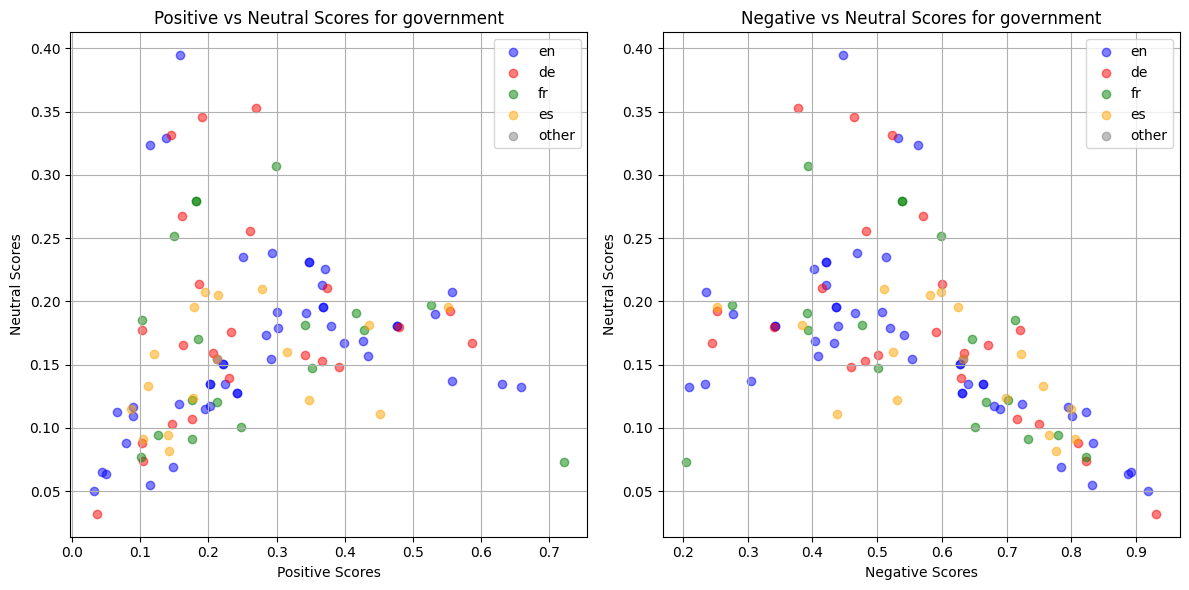

Sentiment statistics of native article
       desc_positive_score  desc_neutral_score  desc_negative_score
count           105.000000          105.000000           105.000000
mean              0.275698            0.146601             0.577701
std               0.160238            0.065299             0.182947
min               0.031199            0.032965             0.161742
25%               0.157216            0.101365             0.439183
50%               0.247454            0.134921             0.586213
75%               0.366563            0.180328             0.720116
max               0.727413            0.394468             0.932000

Sentiment comparison of articles by language
language                          de         en         es         fr
desc_positive_score count  23.000000  47.000000  17.000000  18.000000
                    mean    0.242989   0.280950   0.328952   0.253485
                    std     0.143214   0.159807   0.181596   0.159722
                    min

In [20]:
filter_to_keyword(sentiment_df, "en_description", "government", "en_desc")

It looks like articles are generally negative towards the government no matter what the language is. We see that on average, German and French are the most negative. There doesn't seem to be much difference between the native and English translation, but on average the native translation of the articles are more positive.

Analyzing presidential in en_description
Number of articles that mention presidential in each language
language
fr    54
es     4
en     4
de     1
Name: count, dtype: int64
Compare positive and negative sentiments for presidential


<Figure size 800x600 with 0 Axes>

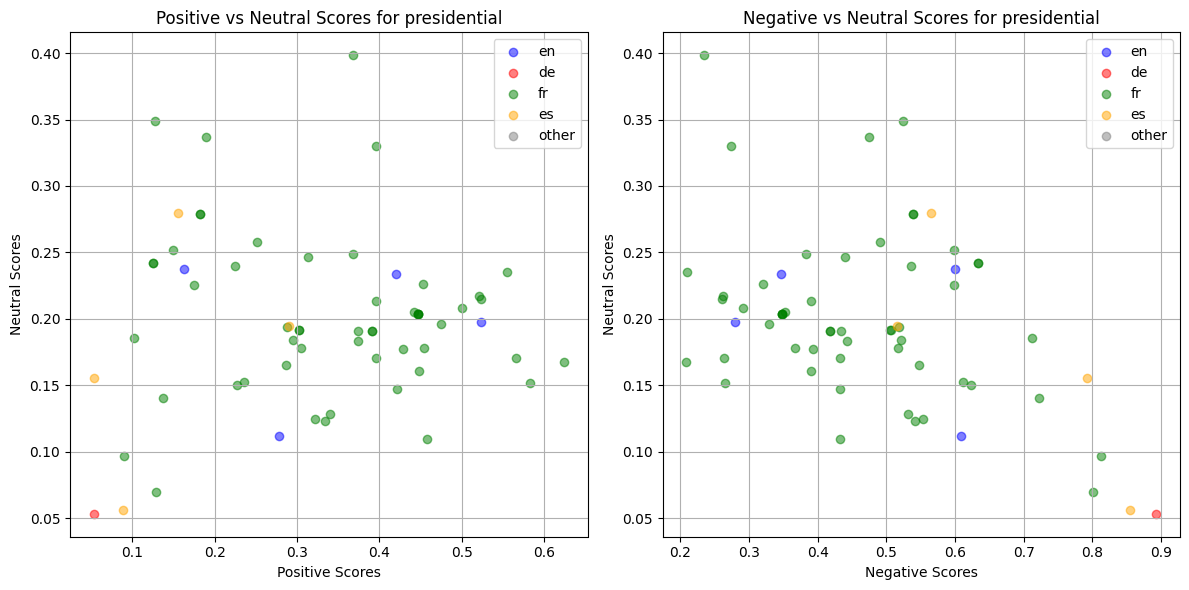

Sentiment statistics of native article
       desc_positive_score  desc_neutral_score  desc_negative_score
count            63.000000           63.000000            63.000000
mean              0.313284            0.166662             0.520054
std               0.165658            0.050252             0.172335
min               0.042823            0.051269             0.219768
25%               0.176480            0.138385             0.344311
50%               0.280061            0.171592             0.547676
75%               0.485767            0.194627             0.666845
max               0.598374            0.293815             0.884427

Sentiment comparison of articles by language
language                         de        en        es         fr
desc_positive_score count  1.000000  4.000000  4.000000  54.000000
                    mean   0.288313  0.345915  0.163713   0.322409
                    std         NaN  0.158399  0.096098   0.168209
                    min    0.288313

In [21]:
filter_to_keyword(sentiment_df, "en_description", "presidential", "en_desc")

It seems that similar to government, articles mentioning presidential are mostly negative.

Analyzing president in en_description
Number of articles that mention president in each language
language
fr    79
de    41
es    34
en    27
Name: count, dtype: int64
Compare positive and negative sentiments for president


<Figure size 800x600 with 0 Axes>

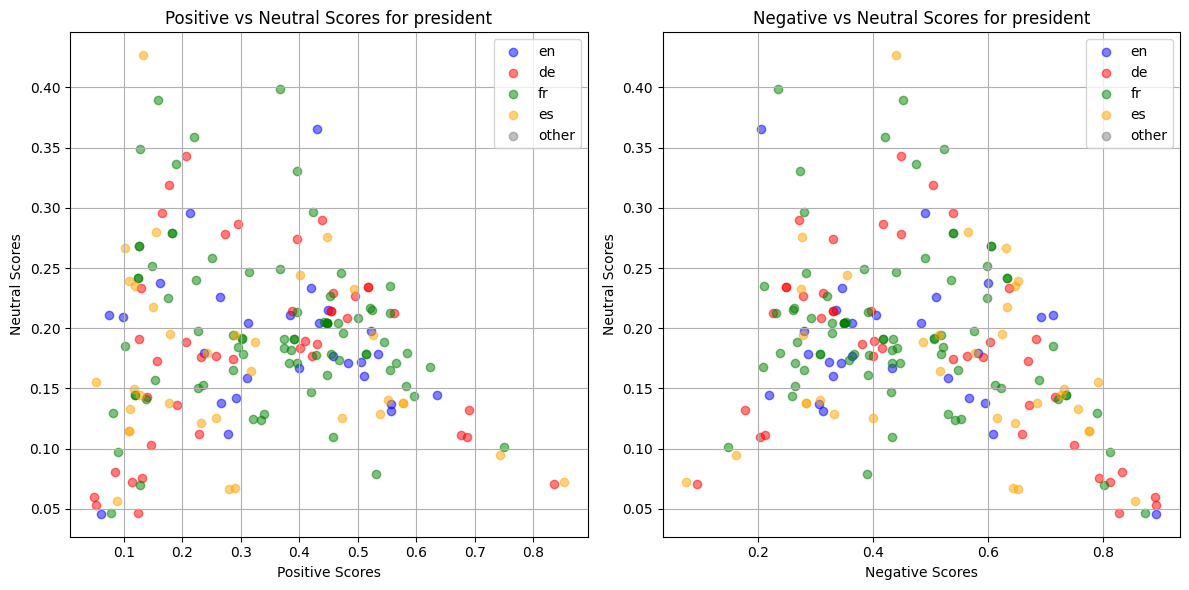

Sentiment statistics of native article
       desc_positive_score  desc_neutral_score  desc_negative_score
count           181.000000          181.000000           181.000000
mean              0.331930            0.159654             0.508417
std               0.179432            0.067658             0.189637
min               0.040245            0.034394             0.048470
25%               0.187536            0.112002             0.346438
50%               0.314265            0.158471             0.507791
75%               0.478226            0.187168             0.644214
max               0.909517            0.445178             0.910801

Sentiment comparison of articles by language
language                          de         en         es         fr
desc_positive_score count  41.000000  27.000000  34.000000  79.000000
                    mean    0.294915   0.365068   0.347927   0.332929
                    std     0.150934   0.158137   0.225821   0.177459
                    min

In [22]:
filter_to_keyword(sentiment_df, "en_description", "president", "en_desc")

There's a lot more points in varied languages when we look at "president" versus "presidential". On average, it's still negative, with German sources much more negative than others on average.

Analyzing pandemic in en_description
Number of articles that mention pandemic in each language
language
de    8
en    5
fr    2
Name: count, dtype: int64
Compare positive and negative sentiments for pandemic


<Figure size 800x600 with 0 Axes>

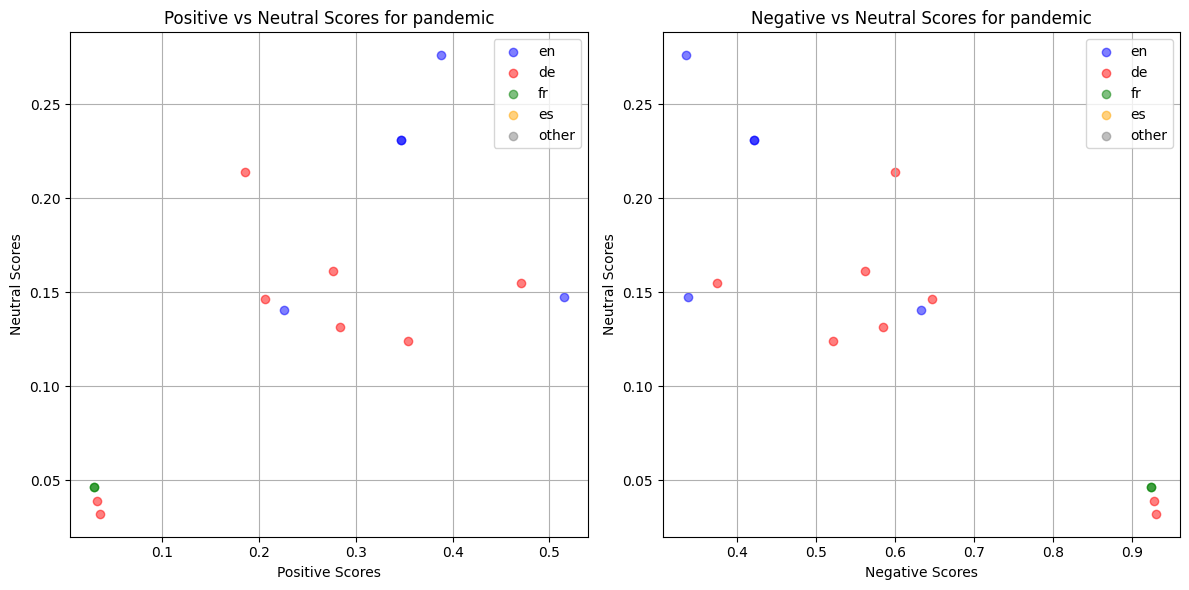

Sentiment statistics of native article
       desc_positive_score  desc_neutral_score  desc_negative_score
count            15.000000           15.000000            15.000000
mean              0.251618            0.139288             0.609094
std               0.165779            0.063014             0.208904
min               0.060455            0.053064             0.335488
25%               0.107199            0.095725             0.415637
50%               0.212709            0.131109             0.651554
75%               0.367802            0.146904             0.780192
max               0.514974            0.276021             0.863035

Sentiment comparison of articles by language
language                         de        en        fr
desc_positive_score count  8.000000  5.000000  2.000000
                    mean   0.228686  0.364775  0.060455
                    std    0.169237  0.103626  0.000000
                    min    0.083457  0.226184  0.060455
                    25%

In [23]:
filter_to_keyword(sentiment_df, "en_description", "pandemic", "en_desc")

There's not too much data here, but it's interesting to see which words are used by different sources. German tended to use pandemic more while English sources used COVID more. Spanish sources used neither of the terms, or terms that translated to "pandemic" or "covid".

Analyzing covid in en_description
Number of articles that mention covid in each language
language
en    9
fr    4
de    1
Name: count, dtype: int64
Compare positive and negative sentiments for covid


<Figure size 800x600 with 0 Axes>

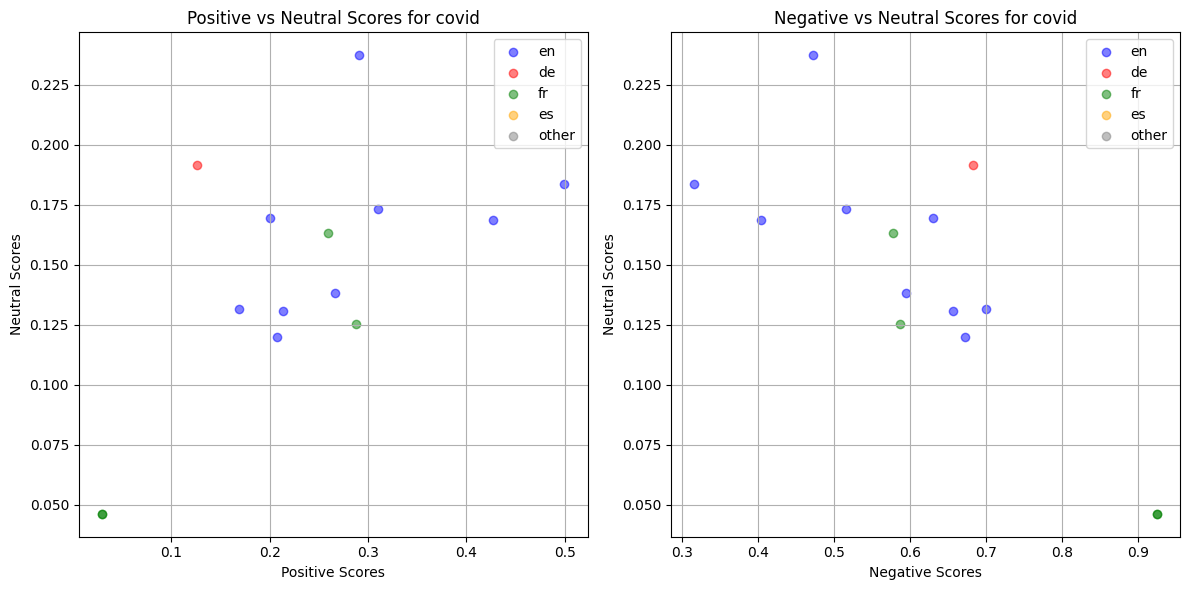

Sentiment statistics of native article
       desc_positive_score  desc_neutral_score  desc_negative_score
count            14.000000           14.000000            14.000000
mean              0.226038            0.139344             0.634618
std               0.131508            0.045025             0.168696
min               0.060455            0.076509             0.316757
25%               0.135794            0.108359             0.533585
50%               0.210156            0.134934             0.643003
75%               0.284798            0.169287             0.752926
max               0.499762            0.237338             0.863035

Sentiment comparison of articles by language
language                         de        en        fr
desc_positive_score count  1.000000  9.000000  4.000000
                    mean   0.067028  0.287173  0.128237
                    std         NaN  0.111303  0.097535
                    min    0.067028  0.168965  0.060455
                    25%

In [24]:
filter_to_keyword(sentiment_df, "en_description", "covid", "en_desc")

Analyzing climate in en_description
Number of articles that mention climate in each language
language
de    13
en    13
es     3
fr     2
Name: count, dtype: int64
Compare positive and negative sentiments for climate


<Figure size 800x600 with 0 Axes>

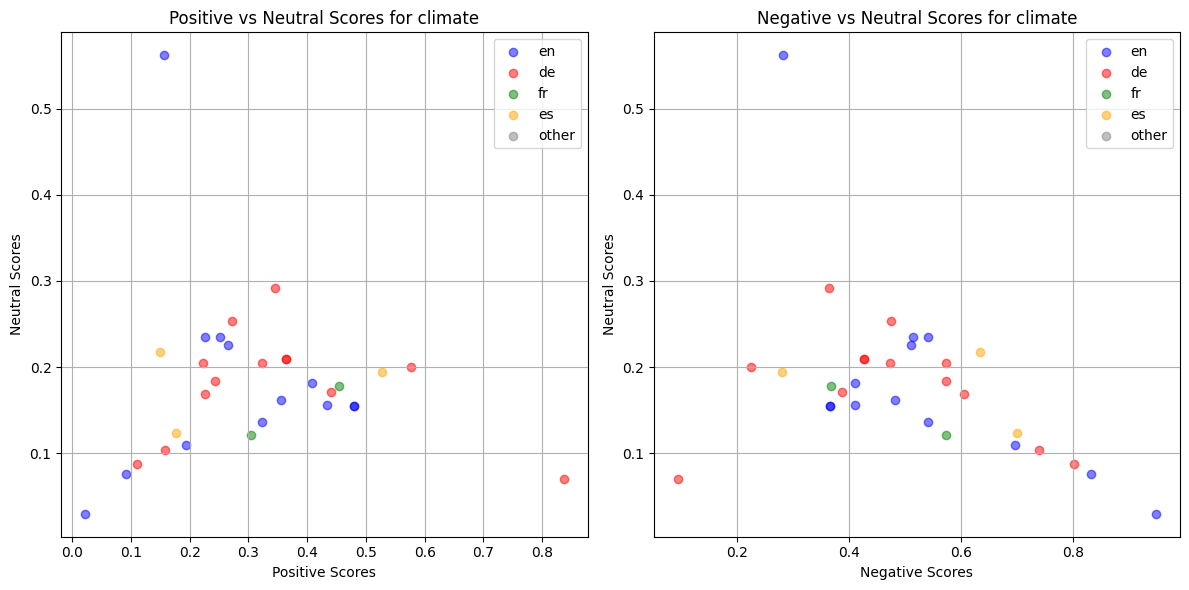

Sentiment statistics of native article
       desc_positive_score  desc_neutral_score  desc_negative_score
count            31.000000           31.000000            31.000000
mean              0.296394            0.151211             0.552395
std               0.181241            0.092101             0.191239
min               0.022357            0.029886             0.031411
25%               0.192507            0.110238             0.409869
50%               0.236694            0.134202             0.540074
75%               0.387457            0.159315             0.680588
max               0.924173            0.561793             0.947757

Sentiment comparison of articles by language
language                          de         en        es        fr
desc_positive_score count  13.000000  13.000000  3.000000  2.000000
                    mean    0.304326   0.283778  0.263920  0.375554
                    std     0.215971   0.146086  0.212845  0.245841
                    min     0.1

In [25]:
filter_to_keyword(sentiment_df, "en_description", "climate", "en_desc")

It looks like German and English sources covered the Climate Conference more than other languages, but it was extremely negative across the board.

Analyzing sudan in en_description
Number of articles that mention sudan in each language
language
de    13
fr     8
Name: count, dtype: int64
Compare positive and negative sentiments for sudan


<Figure size 800x600 with 0 Axes>

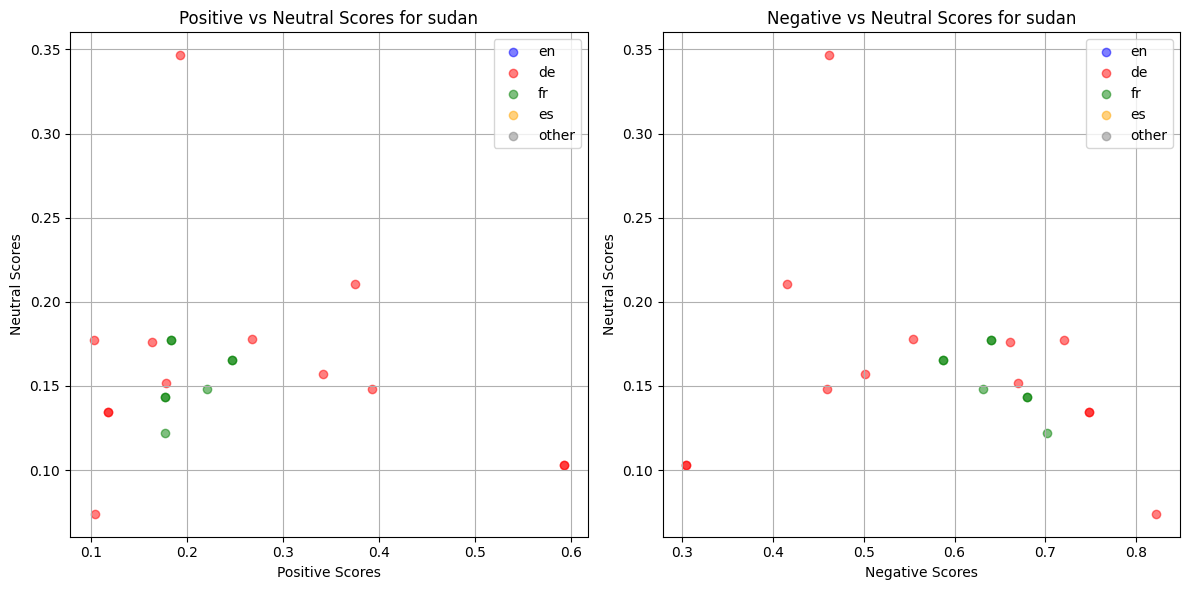

Sentiment statistics of native article
       desc_positive_score  desc_neutral_score  desc_negative_score
count            21.000000           21.000000            21.000000
mean              0.187667            0.103678             0.708655
std               0.084372            0.030189             0.103165
min               0.056595            0.035912             0.535682
25%               0.121759            0.089328             0.632853
50%               0.159497            0.103452             0.721473
75%               0.255519            0.123101             0.788913
max               0.344653            0.168658             0.907494

Sentiment comparison of articles by language
language                          de        fr
desc_positive_score count  13.000000  8.000000
                    mean    0.198310  0.170372
                    std     0.097630  0.058711
                    min     0.056595  0.103583
                    25%     0.112139  0.130603
                    5

In [26]:
filter_to_keyword(sentiment_df, "en_description", "sudan", "en_desc")

Only German and French sources covered the Sudan coup, and also seemed pretty negative. It's interesting to note that none of these keywords resulted in any majorly positive results. Maybe world politics are just depressing.

## Extensions
This dataset contains languages not classifiable by the model used. You could fill this gap by utilizing other models, but for the sake of this analysis I wanted to keep the sentiment model the same for consistency in classification.  
This analysis is limited to the articles in the given dataset, which was free to download. The methods in this notebook could be applied to more data fetched through services like the [Newsdata.io API](https://newsdata.io/datasets) or [NewsNow API](https://rapidapi.com/rphrp1985/api/newsnow) from specifics date or from other topics. However, these services cost money after a certain number of API calls and I am a broke student :( But maybe you aren't!